# Task 1: Implement Linear Classification with Hinge Loss 
# CENG501 - Spring 2023 - PA1

In this task, you will implement a linear classification model with max-margin loss and regularization penalty, a.k.a. SVM Loss. 

*Disclaimer: Many components in this notebook are adapted or taken from [CS231n](https://cs231n.github.io/) materials.*

## 1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [1]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import os                       # Built-in library for filesystem access etc.
import pickle                   # For (re)storing Python objects into (from) files 
import time                     # For measuring time

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## 2 The Dataset

In this task, we will use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR-10 is a relatively small dataset frequently used for proof-of-concept experiments. It consists of 10 object classes ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') with equal number of samples (i.e. a balanced dataset). There are 60,000 32x32 colour images, with 6,000 images per class. 

The dataset provides a split of 50,000 training images and 10,000 test images. For each class, there are 5,000 images for training and 1,000 images for testing.

### 2.1 Download the Dataset

Thankfully, we can directly download the dataset as follows. However, sometimes access to the dataset somehow doesn't work. It is best if you save a downloaded version of the dataset and use it if you have access problems. Using the following cell is faster, however, as the file is directly downloaded to a Google server.

After downloading and uncompressing the file, check the file and the folders using the menu on the left.

In [2]:
# Download the file
! wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

# Extract the compressed file
! tar zxvf cifar-10-python.tar.gz

--2023-04-09 19:42:20--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  17.2MB/s    in 11s     

2023-04-09 19:42:32 (14.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


### 2.2 Load the Dataset

Let us load the images from the filesystem. Note that there are many neat loaders like [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html). For the time being, we will stick to doing things the hard way.

Pay attention to the sizes of the tensors after they are loaded. An image in the CIFAR10 dataset has size 32x32x3 and we will reshape an image into a 1D vector with 3072 elements.

*Disclaimer: This loader is adapted from [CS231n](https://cs231n.github.io/) materials.*

In [3]:
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(cifar10_dir, num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Now use these functions to load the dataset:
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data('cifar-10-batches-py/')

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# Note that 32x32x3 = 3072
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (49000, 3072)
Training labels shape:  (49000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### 2.3 Visualize Some Samples

For sanity check, let us visualize some samples.

*Disclaimer: This code piece is taken from [CS231n](https://cs231n.github.io/) materials.*

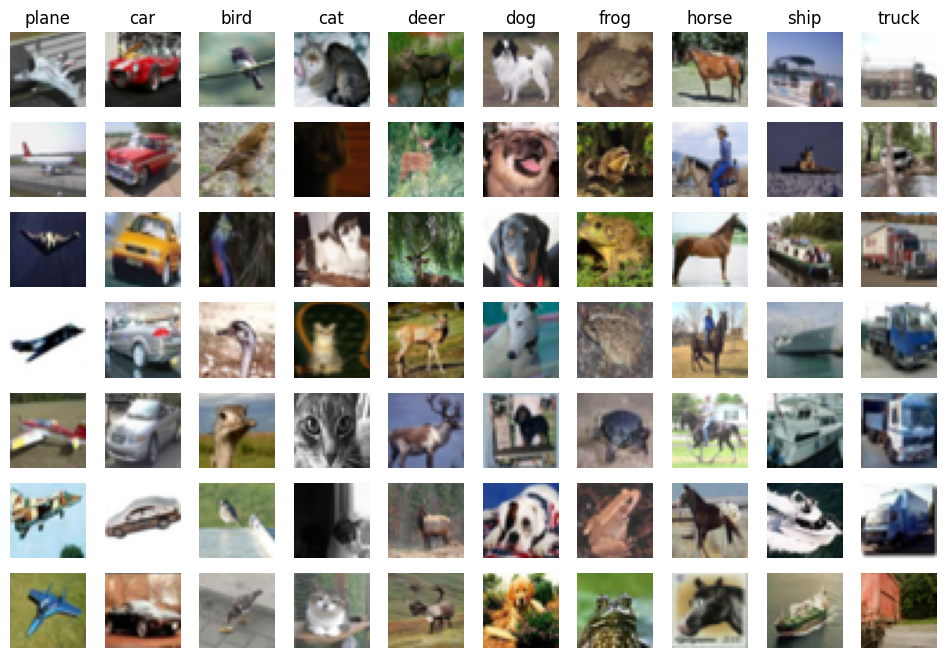

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(32,32,3).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### 2.4 Preprocessing

We will perform two preprocessing steps: Subtracting the mean and adding a bias dimension to the inputs to make things easier for calculations on the weight matrix.

Warning/note: Applying mean substraction again will produce a black image. Why?

*Disclaimer: This step is taken from [CS231n](https://cs231n.github.io/) materials.*

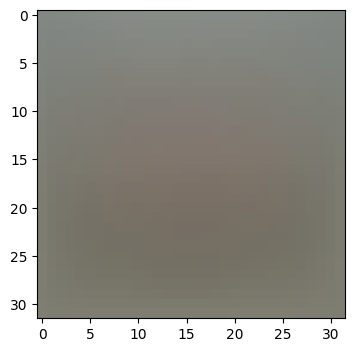

In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_test -= mean_image
X_val -= mean_image

In [6]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (49000, 3073)
Validation data shape:  (1000, 3073)
Test data shape:  (1000, 3073)


## 3 Construct the Model

In this task, we are defining a linear model for classification, as we have seen in the lectures.

### 3.1 A Linear Model

A linear model performs a simple transformation on input $\mathbf{x}\in R^D$ using parameters $W \in R^{C\times D}$, where $D$ is the dimensionality of the input and $C$ is the number of classes (note that $W$ has size $D\times C$ in the implementation to avoid a transpose operation). This transformation can be formally denoted as (note that $\mathbf{x}$ contains a constant 1 for the bias):
$$
f(\mathbf{x}; W) = W\cdot \mathbf{x}. 
$$

If we look at this operation for class $c$, we see that this is simply a dot product:
$$
f(\mathbf{x}; W)_c = \mathbf{w}_c \cdot \mathbf{x} = \sum_{i=1}^D {w}_{ci} x_i. 
$$

Let us first implement this linear operation as a linear layer. In the following cell, complete the "@TODO" parts of `forward_naive()` and `forward_vectorized()` functions. You can ignore the `update()` and `predict()` functions for the time being.


In [13]:
class LinearLayer:

  def __init__(self, D, C):
    """
      Initialize the linear layer. Weights are randomly initialized in a small range.

      D: The dimensionality of a single instance. 
      C: The number of classes.
    """
    self.D = D
    self.C = C
    np.random.seed(501) # for reproducibility, set the seed to a constant
    self.W = 0.001 * np.random.randn(D, C)

  def forward_naive(self, X, W=None):
    """
    Use the current weights to obtain the scores for a batch of samples (X). 
    Use iterations in this version. Iterate over samples & classes & dimensions of X.

    Inputs:
    - X: A numpy array of shape (N, D) containing N samples each of dimension D.
    Returns:
    - scores: A numpy array of shape (N, C). Predicted scores for the data in X.
    """
    scores = np.zeros((X.shape[0], self.C))
    N = X.shape[0] # number of samples
    if W is None: W = self.W

    ###########################################################################
    # @TODO: Implement this method. Store the scores in 'scores' array.       #
    # Hint: You will have three loops nested here. One loop over samples, one #
    # over classes and one over dimensions.                                   #
    ###########################################################################
    for i in range(N):
      for j in range(self.C):
        for k in range(self.D):
          scores[i][j] += W[k][j] * X[i][k]
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return scores

  def forward_vectorized(self, X, W=None):
    """
    Use the current weights to obtain the scores for a batch of samples (X).

    Inputs:
    - X: A numpy array of shape (N, D) containing N samples each of dimension D.
    Returns:
    - scores: A numpy array of shape (N, C). Predicted scores for the data in X. 
    """
    scores = np.zeros((X.shape[0], self.C))
    if W is None: W = self.W

    ###########################################################################
    # @TODO: Implement this method. Store the scores in 'scores' array.       #
    # Hint: This should be a single line of code using numpy functions.       #
    ###########################################################################
    scores = X.dot(W)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return scores

  def predict(self, X):
    """
    Obtain the predictions as discrete labels (integers)

    Inputs:
    - X: A numpy array of shape (N, D) containing N samples each of dimension D.
    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])

    ###########################################################################
    # @TODO: Implement this method. Store the predicted labels in y_pred.     #
    # Hint: You can use forward() to estimate the scores and the predicted    # 
    # label is the class (integer) that has the highest score. Write this in  #
    # vectorized form in a single line. Check function np.argmax()            #
    ###########################################################################
    y_pred = np.argmax(np.dot(X, self.W), axis=1)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred

  def update(self, dW, learning_rate):
    """
    Update the model parameters with the gradients (dW) by scaling with the 
    learning rate.

    Inputs:
    - dW: The derivative of the loss wrt. W. The shapes of self.W and dW must match.
    - learning_rate: The learning rate.
    """
    #########################################################################
    # @TODO:                                                                 #
    # Update the weights using the gradient and the learning rate.          #
    #########################################################################
    self.W -= learning_rate * dW
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################


Let us compare the `forward_naive()` and `forward_vectorized()` functions. We will compare the two implementations in terms of time and outputs.

In [8]:
D = X_train.shape[1] # dimensionality
C = np.max(y_test) + 1 # labels are in 0-9, so we add 1
N = X_train.shape[0]

# Over a set of 10 samples
sample_indices = np.random.choice(range(N), size=10)
X_samples = X_train[sample_indices]

model = LinearLayer(D, C)

# First the naive method
tic = time.time()
scores_naive = model.forward_naive(X_samples)
toc = time.time()
print(f"forward_naive() took {toc-tic}s!")

# Now the vectorized method
tic = time.time()
scores = model.forward_vectorized(X_samples)
toc = time.time()
print(f"forward_vectorized() took {toc-tic}s!")

# Now check whether they have produced the same results
print("\nYou should see zero difference between the scores calculated using the\n"
      "naive method and the vectorized method: %f\n" % 
      np.sum((scores_naive-scores)**2))

forward_naive() took 0.2765076160430908s!
forward_vectorized() took 0.0009171962738037109s!

You should see zero difference between the scores calculated using the
naive method and the vectorized method: 0.000000



You should obtain a difference of zero between the scores returned by the two implementations. You should observe that there is a 300x difference between the running times of the two implementations. For that reason, we should always prefer vectorized implementations.

### 3.2 The Loss Function and the Gradients

In this task, we will train the linear model using Hinge Loss and L2 regularization on the weights, a.k.a. SVM Loss. Formally, we can define this loss as follows:
$$
L = \frac{1}{N} \sum_{i=1}^N \sum_{j\neq y_i} \max(0, s_j - s_{y_i} + \Delta) + \frac{\lambda}{2}\sum_{i,j} w_{i,j}^2,
$$
where $s_j = \sum_k w_{jk} x_k$ is the score for class $j$; $y_i$ is the correct class for sample $\mathbf{x}_i$; $\Delta$ is the margin for max-margin loss and $\lambda$ is the regularization coefficient. With SVM Loss, we will take the margin as 1 (one), but we will leave it as a hyper-parameter in our implementations.

Pay close attention to the loss definition in the above equation. Any discrepancy in your implementation will lead to different outputs. Note that the following implementation includes redundancies in that same quantities are calculated repeatedly. In frameworks, these redundancies are avoided by creating "computation graphs" and performing calculations over the computation graph. However, to simplify the implementation and to make the learning parts more explicit, I chose to trade efficiency.

In the following code segment, implement the `calculate()` and `gradient()` functions.


In [9]:
class SVM_Loss:
  def __init__(self, margin, reg):
    self.margin = margin
    self.reg = reg
  
  def calculate(self, W, scores, y):
    """
    Hinge loss with L2 regularization. Follow the formulation above closely.

    Inputs: 
    - scores: A numpy array with shape (N, C). The scores for each class for each sample.
    - y: A numpy array of integers, shape (N). Stores correct labels for samples.

    Output: - loss: A floating point number, representing the total loss for the samples.
    """
    loss = 0.0
    N = y.size
    reg = self.reg
    margin = self.margin

    #############################################################################
    # @TODO:                                                                    #
    # Implement a vectorized version of the SVM loss in the above equation,     #
    # storing the result in variable `loss`                                     #
    #############################################################################
    # Calculate the scores for the correct classes
    correct_class_scores = scores[np.arange(N), y]
    # Calculate the loss for each sample
    loss_per_sample = np.maximum(0, scores - correct_class_scores[:, np.newaxis] + margin)
    # Set the loss for the correct class to zero
    loss_per_sample[np.arange(N), y] = 0
    # Calculate the total loss
    loss = np.sum(loss_per_sample) / N + 0.5 * reg * np.sum(W * W)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    
    return loss

  def gradient(self, W, X, y, scores):
    """
    Calculates the gradient of the loss wrt. the weights, W. 

    Inputs:
    - X: A numpy array of shape (N, D). The input samples over which we are calculating the gradient.
    - y: A numpy array of integers, shape (N). Stores correct labels for samples.
    - scores: A numpy array with shape (N, C). The scores for each class for each sample.
    
    Output:
    - dW: A numpy array with shape (D, C), same as the shape of W. Stores the gradient
    of the loss wrt. W.
    """
    reg = self.reg
    margin = self.margin
    dW = np.zeros(W.shape) # initialize the gradient as zero
    N = y.size

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #############################################################################
    # Calculate the scores for the correct classes
    correct_class_scores = scores[np.arange(N), y]
    # Calculate the loss for each sample
    loss_per_sample = np.maximum(0, scores - correct_class_scores[:, np.newaxis] + margin)
    # Set the loss for the correct class to zero
    loss_per_sample[np.arange(N), y] = 0
    # Calculate the gradient
    loss_per_sample[loss_per_sample > 0] = 1
    loss_per_sample[np.arange(N), y] = -np.sum(loss_per_sample, axis=1)
    dW = X.T.dot(loss_per_sample) / N + reg * W
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return dW

### 3.3 Check the Gradients

Let us check whether your implementation was correct. For this, we will calculate the gradient numerically and compare it with the analytical gradient we have obtained. 

Remember from your calculus courses that the derivative of a function $f()$ at $x$ can be calculated numerically as follows:

$$
\frac{df(x)}{dx} = \lim_{h\rightarrow \infty} \frac{f(x+h)-f(x)}{h},
$$

which can be approximated by picking a sufficiently small $h$ value: 

$$
\frac{df(x)}{dx} \simeq \frac{f(x+h)-f(x)}{h}.
$$

In practice, a symmetric version is used for better estimatation of the derivative:
$$
\frac{df(x)}{dx} \simeq \frac{f(x+h)-f(x-h)}{2h}.
$$

In the following, you should see differences between the analytical and numerical gradients less than $10^{-10}$ except for a few dimensions as $max()$ function is not strictly differentiable and numerical derivative can slightly differ from the analytic one near the discontinuity. 

If you see low errors, you can assume that our gradient implementation was correct.

In [10]:
from random import randrange

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in these dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])
    oldval = x[ix]

    x[ix] = oldval + h # increment a single dimension of x (W) by h
    fxph = f(x) # evaluate f(x + h)

    x[ix] = oldval - h # decrement by h
    fxmh = f(x) # evaluate f(x - h)
    
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

def f(W): 
  scores = model.forward_vectorized(X_test, W)
  return loss_fn.calculate(W, scores, y_test) #W, scores, y):

# Create 
model = LinearLayer(D, C)
loss_fn = SVM_Loss(margin=1, reg=1e-5)
scores = model.forward_vectorized(X_test)
dW = loss_fn.gradient(model.W, X_test, y_test, scores)
grad_numerical = grad_check_sparse(f, x=model.W, analytic_grad=dW, num_checks=10)

numerical: -10.242672 analytic: -10.242672, relative error: 2.966123e-12
numerical: -15.779766 analytic: -15.779766, relative error: 5.533636e-12
numerical: 8.245639 analytic: 8.245639, relative error: 2.873080e-12
numerical: -10.130510 analytic: -10.130510, relative error: 4.254625e-12
numerical: 7.002059 analytic: 7.002059, relative error: 1.447115e-12
numerical: 7.460923 analytic: 7.460923, relative error: 7.105798e-12
numerical: 4.674056 analytic: 4.674056, relative error: 7.791991e-12
numerical: 4.234160 analytic: 4.234160, relative error: 1.529512e-11
numerical: -20.745378 analytic: -20.745378, relative error: 4.778052e-12
numerical: 2.711827 analytic: 2.711827, relative error: 6.041031e-12


### 3.4 Training Method

Okay, it seems that we have most of the ingredients ready, except for a few things. Go back to the implementation of the `LinearModel` and complete the `update()` function. Then come back here and define the train function (just click run).

In [11]:
def sample_batch(X, y, batch_size):
  """Get a random batch of size batch_size from (X, y)."""
  batch_indices = np.random.choice(range(X.shape[0]), size=batch_size)
  X_batch = X[batch_indices]
  y_batch = y[batch_indices]

  return X_batch, y_batch

def train(model, loss_fn, X, y, learning_rate=1e-3, epochs=10, batch_size=32, verbose=False):
  """
    Train this linear classifier using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.
    Outputs:
    A list containing the value of the loss function at each training iteration.
  """
  num_train, dim = X.shape

  # Run stochastic gradient descent to optimize W
  loss_history = []
  for epoch in range(epochs):
    for it in range(int(num_train/batch_size)): 
        
      # Get a batch of samples
      X_batch, y_batch = sample_batch(X, y, batch_size)

      # Feed-forward through the model
      scores = model.forward_vectorized(X_batch)

      # Calculate the loss
      loss = loss_fn.calculate(model.W, scores, y_batch)
      loss_history.append(loss)

      # Calculate the gradient
      dW = loss_fn.gradient(model.W, X_batch, y_batch, scores)

      # perform parameter update
      model.update(dW, learning_rate)

    if verbose: print(f'Epoch {epoch} / {epochs}: {loss}')
      
  return loss_history

## 4 Train the Model

Now, all the pieces are ready and we can train the model. This will be very easy.

In [14]:
num_of_classes = np.max(y_test) + 1 # assume y takes values 0...K-1 where K is number of classes
num_of_samples, num_of_dim = X_train.shape

model = LinearLayer(num_of_dim, num_of_classes)
loss_fn = SVM_Loss(margin=1, reg=1e3)

loss_history = train(model, loss_fn, X_train, y_train, learning_rate=1e-5, epochs=7, batch_size=200, verbose=True)

Epoch 0 / 7: 26.047385042937464
Epoch 1 / 7: 27.57467498083118
Epoch 2 / 7: 27.451262132783228
Epoch 3 / 7: 25.054606281742174
Epoch 4 / 7: 18.809005311558135
Epoch 5 / 7: 34.61091191637591
Epoch 6 / 7: 24.99229743438229


## 5 Analyze Results

We have trained our model and now we should analyze how well it performed. We should look at several factors:

* The loss curve.
* Quantitative analysis of the performance.
* Visual analysis of the weights and the predictions.

### 5.1 The Loss Curve

One of the first things we should do when analyzing a model is to plot the loss curve. We should ideally see a smoothly decreasing curve over iterations/epochs.

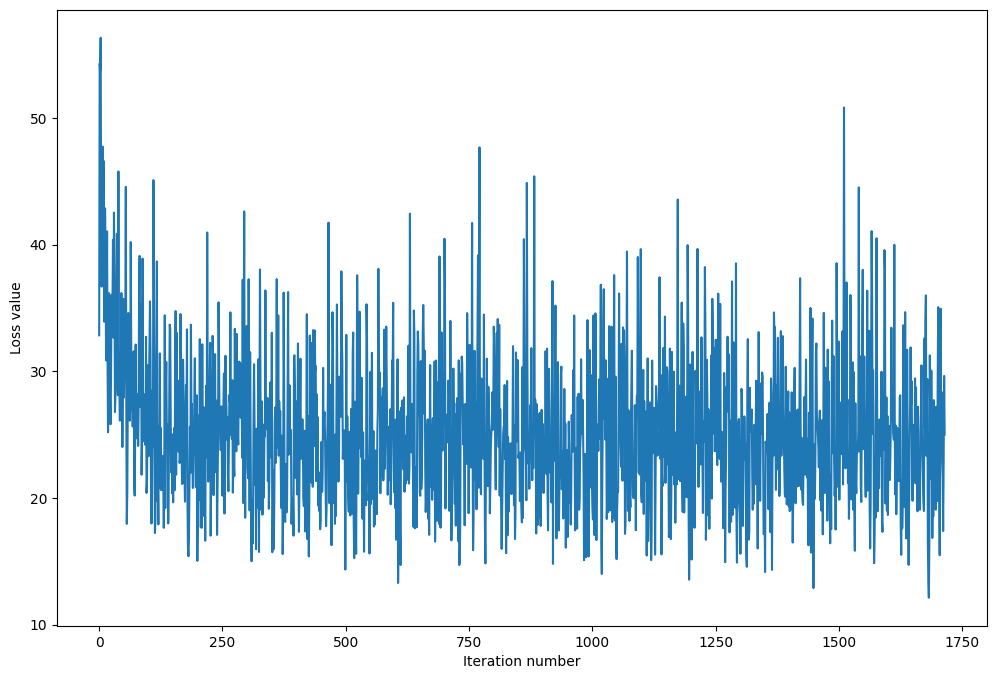

In [15]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 5.2 Quantitative Analysis

Go back to the `LinearModel` implementation and complete the definition of the `predict()` function. Recreate and retrain the model (as the class definition has been updated) -- i.e. run Section 4 again. Then, we can analyze the accuracy of the predictions as follows. You should see around 25\%-26\% accuracies.

In [16]:
y_train_pred = model.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))

y_val_pred = model.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.259653
validation accuracy: 0.261000


### 5.3 Visual Results

Let us look at some visual results. You should see that many of the predictions are off, as we should expect from low accuracy values. This is expected since a linear model is limited for such a classification problem.

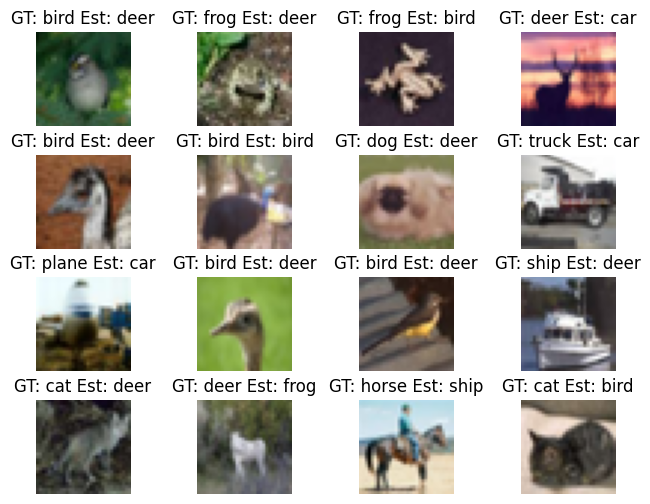

In [17]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

S = 4 # SxS random samples will be selected and drawn

plt.rcParams['figure.figsize'] = [8, 6]

for i in range(S):
  for j in range(S):
    id = np.random.randint(y_test.shape[0])
    X = X_test[id]
    y = y_test[id]
    plt.subplot(S, S, i*S+j+1)
    plt.imshow((X[:-1]+mean_image).reshape(32,32,3).astype('uint8'))
    pred = model.predict(X.reshape(1, 3073))
    plt.axis('off')
    plt.title("GT: " + classes[y] + " Est: " + classes[pred[0]])
    plt.subplots_adjust(hspace = 0.3)

plt.show()
plt.rcParams['figure.figsize'] = [6, 4]

### 5.4 Visualize Weights

Let us visualize the weights for each class. You should see images that look like templates for each class.

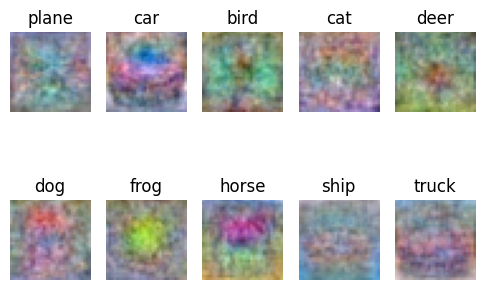

In [19]:
w = model.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## 6 Tune your Model

In Section 4, we trained our model with some arbitrary hyperparameters. In general, we are not going to be lucky enough to get suitable results with our first shot. Let us finetune our hyperparameters (learning rate and regularization strength) and see whether we can get better results.

### 6.1 Find the Best Hyperparameters

Let us train the model for different values for our hyperparameters. Embrace yourselves for some long training time as we will train 27 models! Well, at least longer than what we had in Section 4. To reduce the waiting time, we will train the models for 3 epochs and train the best model longer later on.

In [20]:
learning_rates = [1e-7, 1e-6, 1e-5]
regularization_strengths = [1e3, 2e3, 3e3, 1e4, 2e4, 3e4, 1e5, 2e3, 3e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearLayer object that achieved the highest validation rate.
best_lr = None  # The learning rate for the best model
best_rg = None  # The regularization strength for the best model

for lr in learning_rates:
  for rg in regularization_strengths:
    ############################################################################
    # @TODO: Write your code below in the parts marked with @TODO              #
    ############################################################################
    
    ## @TODO: Create a new SVM instance
    model = LinearLayer(D, C)

    ## @TODO: Create a new loss instance with current rg and margin=1
    loss = SVM_Loss(margin=1, reg=rg)

    ## @TODO: Train with the training set with current lr and rg for 3 epochs
    loss_history = train(model, loss, X_train, y_train, lr, 3)

    # @TODO: Predict values for training set and the validation set
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    ############################################################################
    #                              END OF YOUR CODE                            #
    ############################################################################
    
    # Calculate training and validation accuracies
    train_accuracy = np.mean(y_train_pred == y_train)
    val_accuracy = np.mean(y_val_pred == y_val)

    print(f"learning rate={lr} and regularization={rg:E} provided train_accuracy={train_accuracy:.3f} and val_accuracy={val_accuracy:.3f}")
    
    # Save the results
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_lr = lr
        best_rg = rg
        best_val = val_accuracy
        best_model = model
    
print(f'\nbest validation accuracy achieved during cross-validation: {best_val} with params reg={best_rg} and lr={best_lr}')

learning rate=1e-07 and regularization=1.000000E+03 provided train_accuracy=0.347 and val_accuracy=0.343
learning rate=1e-07 and regularization=2.000000E+03 provided train_accuracy=0.362 and val_accuracy=0.360
learning rate=1e-07 and regularization=3.000000E+03 provided train_accuracy=0.368 and val_accuracy=0.362
learning rate=1e-07 and regularization=1.000000E+04 provided train_accuracy=0.359 and val_accuracy=0.366
learning rate=1e-07 and regularization=2.000000E+04 provided train_accuracy=0.345 and val_accuracy=0.356
learning rate=1e-07 and regularization=3.000000E+04 provided train_accuracy=0.336 and val_accuracy=0.357
learning rate=1e-07 and regularization=1.000000E+05 provided train_accuracy=0.316 and val_accuracy=0.331
learning rate=1e-07 and regularization=2.000000E+03 provided train_accuracy=0.362 and val_accuracy=0.360
learning rate=1e-07 and regularization=3.000000E+05 provided train_accuracy=0.285 and val_accuracy=0.295
learning rate=1e-06 and regularization=1.000000E+03 pro

<ipython-input-9-61b7ea4c0811>:33: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(loss_per_sample) / N + 0.5 * reg * np.sum(W * W)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-9-61b7ea4c0811>:33: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(loss_per_sample) / N + 0.5 * reg * np.sum(W * W)
<ipython-input-9-61b7ea4c0811>:72: RuntimeWarning: overflow encountered in multiply
  dW = X.T.dot(loss_per_sample) / N + reg * W
<ipython-input-9-61b7ea4c0811>:29: RuntimeWarning: invalid value encountered in subtract
  loss_per_sample = np.maximum(0, scores - correct_class_scores[:, np.newaxis] + margin)
<ipython-input-9-61b7ea4c0811>:66: RuntimeWarning: invalid value encountered in subtract
  loss_per_sample = np.maximum(0, scores - correct_class_scores[:, np.newaxis] + margin)


learning rate=1e-05 and regularization=3.000000E+05 provided train_accuracy=0.100 and val_accuracy=0.087

best validation accuracy achieved during cross-validation: 0.366 with params reg=10000.0 and lr=1e-07


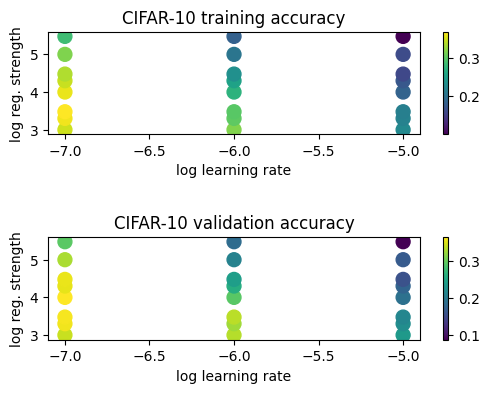

In [21]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log reg. strength')
plt.title('CIFAR-10 training accuracy')
plt.subplots_adjust(hspace = 1)

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log reg. strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

### 6.2 Train the Best Model 

Let us train the model model with the best hyperparameters for longer.

In [22]:
# Train the best model longer
best_model = LinearLayer(num_of_dim, num_of_classes)
loss_fn = SVM_Loss(margin=1, reg=best_rg)
loss_history = train(best_model, loss_fn, X_train, y_train, learning_rate=best_lr, epochs=5, batch_size=200, verbose=True)
    

Epoch 0 / 5: 101.24803281120931
Epoch 1 / 5: 63.00783940247082
Epoch 2 / 5: 39.82226556615205
Epoch 3 / 5: 26.35439963248965
Epoch 4 / 5: 17.58967170289371


### 6.3 Analyze the Best Model

Let us analyze some aspects of the best model. To keep things short, let us just look at the loss history and the accuracy. If you like, you can repeat some of the analyses in Section 5 here.

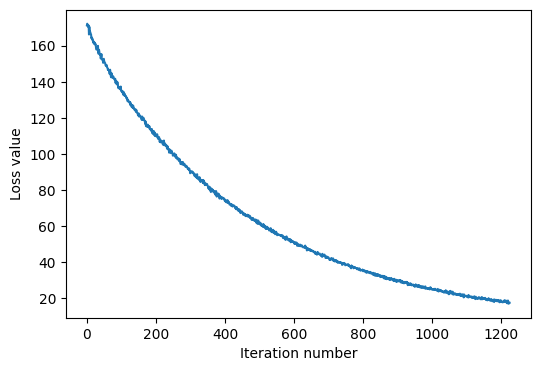

In [23]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Let us look at the accuracies again. We will see that tuning definitely improved the accuracies (from ~25\% to 36\%). With some more fine-grained tuning, it is possible to get up to 40\% accuracies.

In [24]:
y_train_pred = best_model.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))

y_val_pred = best_model.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.355694
validation accuracy: 0.356000
